# Homicidios en Colombia 2010 - 2021

## Importación de librerías

In [1]:
!pip install geopandas xlrd==1.2.0 rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 103 kB 49.0 MB/s 
     |████████████████████████████████| 16.7 MB 884 kB/s 
     |████████████████████████████████| 6.3 MB 36.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [2]:
import pandas as pd
import geopandas as gpd
import re
import os
import matplotlib.pyplot as plt

import imageio
import rarfile

In [126]:
list_texts = [re.findall('^h\w+\.xls[x]?', i)[0] for i in os.listdir() if len(re.findall('^h', i))!= 0]

## Importación de datos

### Población

In [7]:
pob_1 = pd.read_excel('/content/anexo-area-proyecciones-poblacion-Municipal_Area_1985-2017.xlsx', skiprows=11)
pob_2 = pd.read_excel('/content/anexo-proyecciones-poblacion-Municipal_Area_2018-2035 (1).xlsx', skiprows=11)

### Homicidios

In [127]:
list_dfs = [pd.read_excel(i, skiprows=9) for i in list_texts]

### Geoinfo

In [15]:
with rarfile.RarFile('/content/MGN2021_MPIO_POLITICO.rar') as rf:
  for doc in rf.namelist():
    rf.extract(doc)

geo = gpd.read_file('/content/MGN_MPIO_POLITICO.shp')

## Limpieza de datos y creación de columnas de homicidios

In [ ]:
for idx, i in enumerate(list_dfs):
  df = i.copy()
  if 'Unna' in df.columns[0]:
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)
    print(df)
  df = df.drop(index=df.iloc[-5:].index)
  list_dfs[idx] = df

In [ ]:
for i in list_dfs:
  i.columns = i.columns.str.replace('*', ' ').str.strip().str.lower().str.replace(' ', '_')

In [148]:
list_dfs[6].rename(columns={'fecha': 'fecha_hecho'}, inplace=True)

In [149]:
df = pd.concat(list_dfs, ignore_index=True)

In [150]:
df['fecha_año'] = pd.to_datetime(df['fecha_hecho']).dt.year
df['delito'] = 'homicidio'
df['codigo_dane'] = (df['codigo_dane'].astype('int') / 1000).astype('int')

## Base de num_homicidios

In [151]:
num_homicidios = df.pivot_table(index=['municipio', 'codigo_dane', 'fecha_año'],
               values='cantidad',
               aggfunc='sum').reset_index()

In [287]:
num_homicidios.sample(5)

,municipio,codigo_dane,fecha_año,cantidad
2171,COVEÑAS,70221,2012,3.0
2690,EL DOVIO,76250,2018,4.0
416,ANSERMANUEVO,76041,2013,20.0
537,ARBELÁEZ,25053,2013,2.0
1530,CAREPA,5147,2015,8.0


## Limpieza de datos de población

In [8]:
pob_1 = pob_1[(pob_1['ÁREA GEOGRÁFICA'] == 'Total') & (pob_1['AÑO'] >= 2010)].reset_index(drop=True).astype({'COD_MUNICIPIO':int, 'AÑO':int})

In [9]:
pob_2 = pob_2[(pob_2['ÁREA GEOGRÁFICA'] == 'Total') & (pob_2['AÑO'] <= 2021)].reset_index(drop=True)

In [10]:
pob_2.columns = pob_1.columns

In [11]:
pob = pd.concat([pob_1, pob_2], axis=0).drop(columns=['ÁREA GEOGRÁFICA', 'DP'])

## Merge

In [27]:
num_homs = num_homicidios.merge(pob, left_on=['codigo_dane', 'fecha_año'], right_on=['COD_MUNICIPIO', 'AÑO'], how='left')

In [28]:
num_homs['tasa_homicidios'] = num_homs['cantidad'] / num_homs['Total'] * 100000
num_homs.columns = num_homs.columns.str.lower()
num_homs = num_homs.drop(columns=['cod_municipio', 'año', 'mpnom']).rename(columns={'total':'pob'})

In [288]:
num_homs.sample(10)

,municipio,codigo_dane,fecha_año,cantidad,dpnom,pob,tasa_homicidios
1025,BOGOTÁ D.C. (CT),11001,2011,1638.0,"Bogotá, D.C.",7152656,22.900584
4822,MARQUETALIA,17444,2019,4.0,Caldas,13368,29.922202
6075,PRADERA,76563,2017,34.0,Valle del Cauca,47261,71.940924
4362,LA VIRGINIA,66400,2021,8.0,Risaralda,28197,28.371813
5196,MOÑITOS,23500,2013,7.0,Córdoba,27574,25.386233
8209,SILVIA,19743,2015,2.0,Cauca,35280,5.668934
6376,PUERTO RICO,50590,2010,9.0,Meta,12808,70.268582
1031,BOGOTÁ D.C. (CT),11001,2017,1137.0,"Bogotá, D.C.",7337449,15.495849
6627,REPELÓN,8606,2016,2.0,Atlántico,25143,7.954500
659,ARMENIA (CT),63001,2018,88.0,Quindio,295208,29.809490


## Limpieza y exploración geoinfo

In [16]:
geo['MPIO_CDPMP'] = geo['MPIO_CDPMP'].astype(int)

In [17]:
geo.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry
0,05,001,5001,ANTIOQUIA,MEDELLÍN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360..."
1,05,002,5002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05,004,5004,ANTIOQUIA,ABRIAQUÍ,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((-76.08351 6.75050, -76.08325 6.75048..."
3,05,021,5021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((-75.03320 6.41586, -75.03313 6.41585..."
4,05,030,5030,ANTIOQUIA,AMAGÁ,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((-75.67587 6.08561, -75.67540 6.08491..."


## Merge

In [29]:
geo_df = geo[['MPIO_CDPMP', 'geometry', 'MPIO_CNMBR']]
lista_dfs_geo = []
for year in num_homs['fecha_año'].unique():
  df_prov = num_homs[num_homs['fecha_año'] == year]
  lista_dfs_geo.append(geo_df.merge(df_prov, left_on='MPIO_CDPMP', right_on='codigo_dane', how='left').assign(fecha_año=year))

In [30]:
geo_homs = pd.concat(lista_dfs_geo)

In [31]:
geo_homs_not_na = geo_homs.dropna(subset=['fecha_año'])

In [ ]:
num_homs

In [32]:
hom_max = geo_homs['tasa_homicidios'].max()
hom_min = geo_homs['tasa_homicidios'].min()

## Gráficas

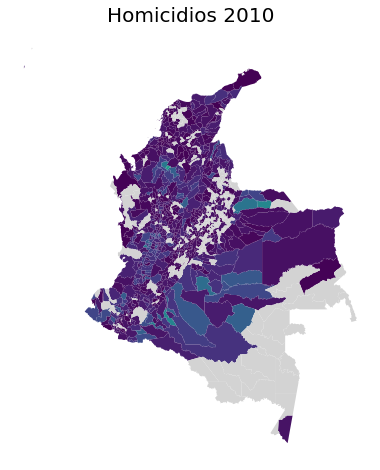

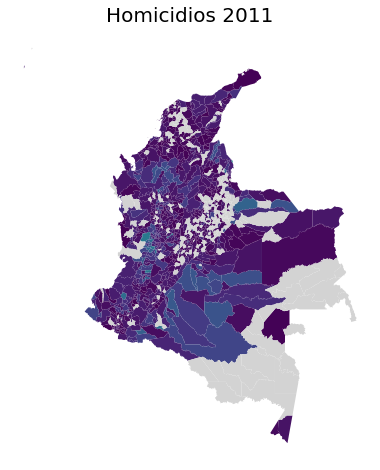

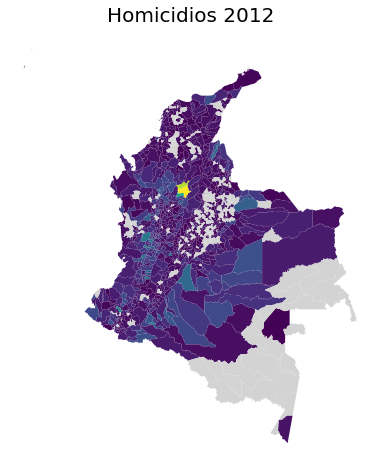

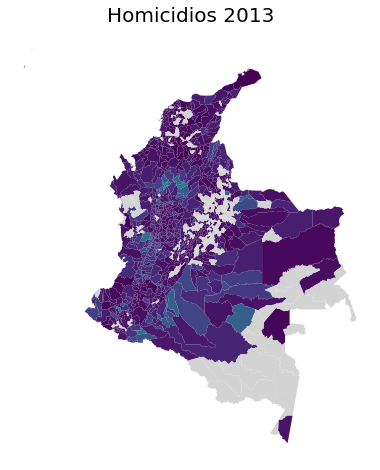

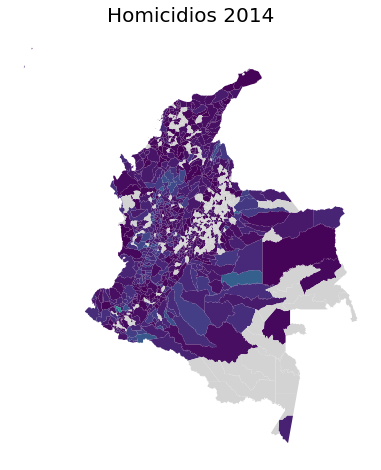

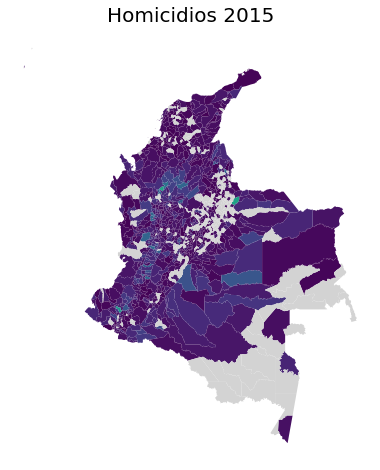

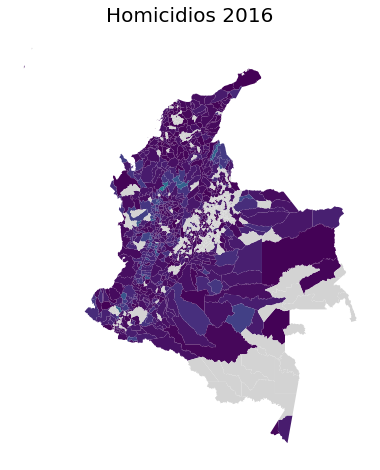

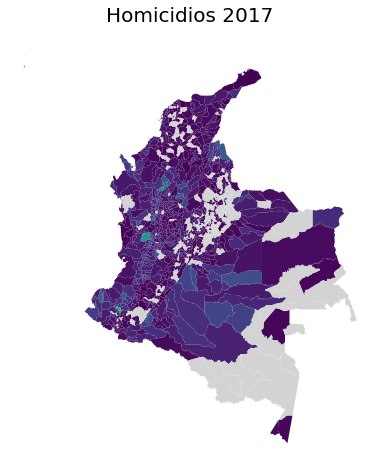

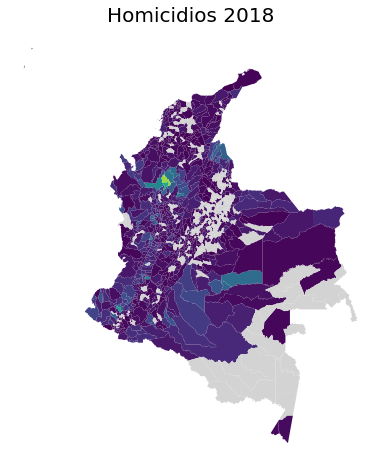

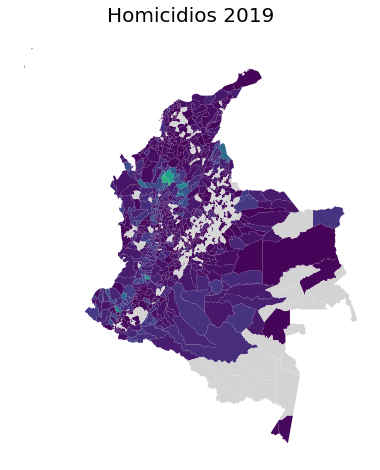

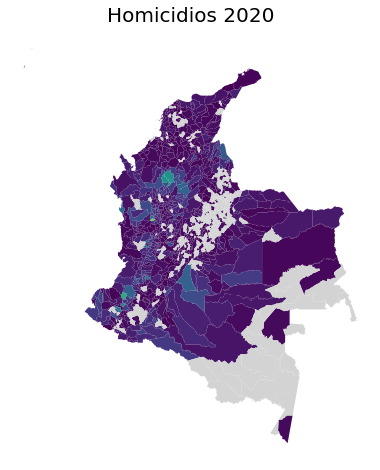

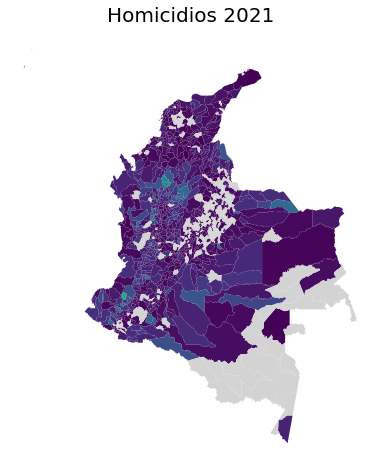

In [33]:
for fecha in geo_homs_not_na['fecha_año'].unique():
  geo_pas = geo_homs[geo_homs['fecha_año'] == fecha]

  fig, ax = plt.subplots(1, 1, figsize=(14, 8))
  geo_pas.plot('tasa_homicidios', figsize=(14, 8), missing_kwds=dict(color = "lightgrey",),ax=ax, vmin=hom_min, vmax=hom_max)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_title(f'Homicidios {int(fecha)}', size=20)
  plt.tick_params(left = False, bottom = False)
  ax.set_xticks([])
  ax.set_yticks([])
  fig.savefig(f'homicidios{int(fecha)}.png')
  plt.show()

## Creación de gif

In [35]:
imgs = [re.findall('\w+\.png', i)[0] for i in os.listdir() if len(re.findall('\w+\.png', i))>0 ]

imgs = sorted(imgs)
with imageio.get_writer('my_gif.gif', mode='I', fps=0.8) as writer:
  for filename in imgs:
    image = imageio.imread(filename)
    writer.append_data(image)

## Guardar dataframes

In [ ]:
df.to_csv('homicidios_anuales.csv', index=False)
num_homicidios.to_csv('num_homicidios_anuales.csv', index=False)
num_homs.to_csv('data_homs.csv', index=False)
